In [1]:
import os
import glob
import arviz as az
import numpy as np
import pandas as pd
from pytensor.tensor import TensorVariable
from typing import Optional, Tuple
import pytensor.tensor as pt

import pymc as pm
# import jax
# #import seaborn as sns
# # import aesara
# # import aesara.tensor as at
# # import pytensor.tensor as pt
# import matplotlib.pyplot as plt
# import xarray as xr
# import re
# from scipy import stats
# from scipy.special import logit
# from scipy.special import expit as logist
# from matplotlib.axes import Axes
# import matplotlib.colors as mcolors
# import matplotlib.patches as mpatches
# from typing import List
# from pandas import DataFrame
# import sys
# import pickle

# import jax
# jax.default_backend()
# jax.devices()

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

In [2]:
path_out = './pymc_model'
with open(os.path.join('pymc_model','brain_16mm_vshd.pkl'),'rb') as f:
    inputBrain16um = pickle.load(f)

In [3]:
df = inputBrain16um['dsg']
inf_aver = inputBrain16um['wsf']

Test pymc dimensions model before model runing

$ 
\text{M_g}\\
\omega_{s,f}\\
\text{g_f,g} \text{  ; input variable from sgRNA refference data}\\
\text{s_e,g}\\
\text{y_s}\\
$

Dmension to test:
- [] Number of features: 13
- [] Number of Genes: 200
- [] Number of spots (cells):1000


In [2]:
g_gf = pm.draw(pm.NegativeBinomial.dist(mu=100, alpha=12, size = 13), draws=200, random_seed=RANDOM_SEED)
M_g = pm.draw(pm.NegativeBinomial.dist(mu=100, alpha=12), draws=200, random_seed=RANDOM_SEED)
W_sf = pm.draw(pm.NegativeBinomial.dist(mu=100, alpha=12, size = 1000), draws=13, random_seed=RANDOM_SEED)
S_eg = pm.draw(pm.NegativeBinomial.dist(mu=100, alpha=12), draws=200, random_seed=RANDOM_SEED)
Y_s = pm.draw(pm.NegativeBinomial.dist(mu=100, alpha=12), draws=200, random_seed=RANDOM_SEED)

In [3]:
with pm.Model() as model:
    M_g = pm.NegativeBinomial("M_g",mu=100, alpha=12, size = (1,200))
    W_sf = pm.NegativeBinomial("W_sf",mu=100, alpha=12, size = (1000,13))
    S_eg = pm.NegativeBinomial("S_eg",mu=100, alpha=12, size = (1,200))
    y_s = pm.NegativeBinomial("y_s",mu=100, alpha=12, size = (1000,1))
    w = pm.Deterministic("w",pm.math.dot(W_sf,g_gf.T))
    m = pm.Deterministic("m",w*M_g)
    mws = pm.Deterministic("mws",m+S_eg)
    mu = pm.Deterministic("mu",mws*y_s)

In [4]:
print(f'g_gf = {g_gf.shape} \n M_g = {M_g.eval().shape} \n W_sf = {W_sf.eval().shape} \n S_eg = {S_eg.eval().shape} \n y_s = {y_s.eval().shape} \n result: w = {w.eval().shape} ')

g_gf = (200, 13) 
 M_g = (1, 200) 
 W_sf = (1000, 13) 
 S_eg = (1, 200) 
 y_s = (1000, 1) 
 result: w = (1000, 200) 


In [5]:
print(f'result: \n w = {w.eval().shape} \n m = {m.eval().shape} \n mws = {mws.eval().shape} \n mu = {mu.eval().shape}')

result: 
 w = (1000, 200) 
 m = (1000, 200) 
 mws = (1000, 200) 
 mu = (1000, 200)


<center>cell2loc model with simulate data

In [6]:
#Inputs:
g_gf = pm.draw(pm.NegativeBinomial.dist(mu=100, alpha=12, size = 13), draws=200, random_seed=RANDOM_SEED)
d_sg = pm.draw(pm.NegativeBinomial.dist(mu=100, alpha=12, size = 200), draws=1000, random_seed=RANDOM_SEED)
ngens = 200
nspost = 1000
nfeat = 13

In [7]:
with pm.Model() as simNB_model:
    mu_m = pm.Gamma("mu_m",1,1)
    o_m = pm.Exponential("o_m",3)
    a_m = pm.Deterministic("a_m",1/o_m**2)
    m_g = pm.Gamma("m_g",a_m,a_m/mu_m,shape = (1,200))
    
    a_y = pm.Gamma("a_y",10,10/20)
    y_s = pm.Gamma("y_s",10,10/30,shape = (1000,1))
    
    b0 = pm.Gamma("b0",9,3,shape = 2)
    o_g = pm.Exponential("o_g",b0[0], shape = (1000,1))
    a_g = pm.Deterministic("a_g",1/o_g**2)
    
    o_es = pm.Exponential("o_es",b0[1])
    a_es = pm.Deterministic("a_es",1/o_es**2)
    mu_es = pm.Gamma("mu_es",1,100)
    s_eg = pm.Gamma("s_eg",a_es,a_es/mu_es,shape = (1,200))
    
    
    k_r  = pm.Gamma("k_r",7,1)
    x_rf  = pm.Gamma("x_rf",k_r/50,k_r,shape = (50,13))
    B_s = pm.Gamma("B_s",7,1) 
    N_s =pm.Gamma("N_s",4*5,5) #4 cells per spot vn =5 acording to seggestion of section 2.1  
    z_sr  = pm.Gamma("z_sr",B_s/50,1/(N_s/B_s),shape = (1000,50))
    mu_sf = pm.Deterministic("mu_sf",pm.math.dot(z_sr,x_rf))
    w_sf = pm.Gamma("w_sf",alpha = mu_sf.eval()*10, beta =10)
    
    musg1_p1 = pm.math.dot(w_sf,g_gf.T)
    musg1_p2 = m_g * musg1_p1
    musg1_p3 = musg1_p2+s_eg
    musg1_p4 = pm.Deterministic("musg1_p4",musg1_p3*y_s)
    
    count = pm.NegativeBinomial("count", mu=musg1_p4, alpha=a_g, observed=d_sg)

In [8]:
count.eval()

array([[819, 664, 769, ..., 840, 726, 623],
       [412, 342, 403, ..., 391, 272, 414],
       [195, 221, 197, ..., 257, 139, 171],
       ...,
       [469, 352, 493, ..., 730, 383, 287],
       [385, 413, 446, ..., 477, 474, 381],
       [467, 349, 360, ..., 465, 452, 372]])

In [9]:
from pymc.variational.callbacks import CheckParametersConvergence

In [10]:
with simNB_model:
    mean_field = pm.fit(method="advi", callbacks=[CheckParametersConvergence()])

Output()

Finished [100%]: Average Loss = 1.1001e+06


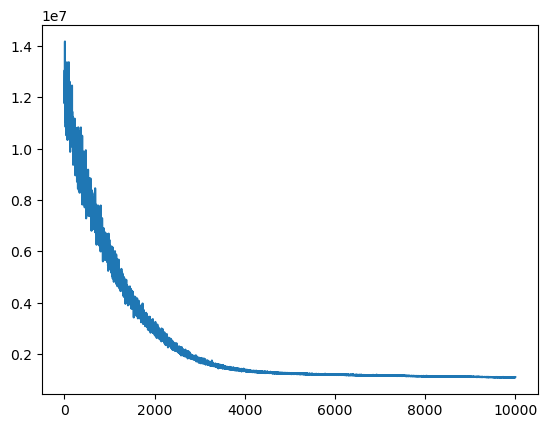

In [11]:
plt.plot(mean_field.hist);

/gpfs/gsfs10/users/kanferg/conda/envs/pymc_latest/lib/python3.12/site-packages/arviz/plots/plot_utils.py:272: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (280062) in plot_posterior, generating only 40 plots
  warnings.warn(


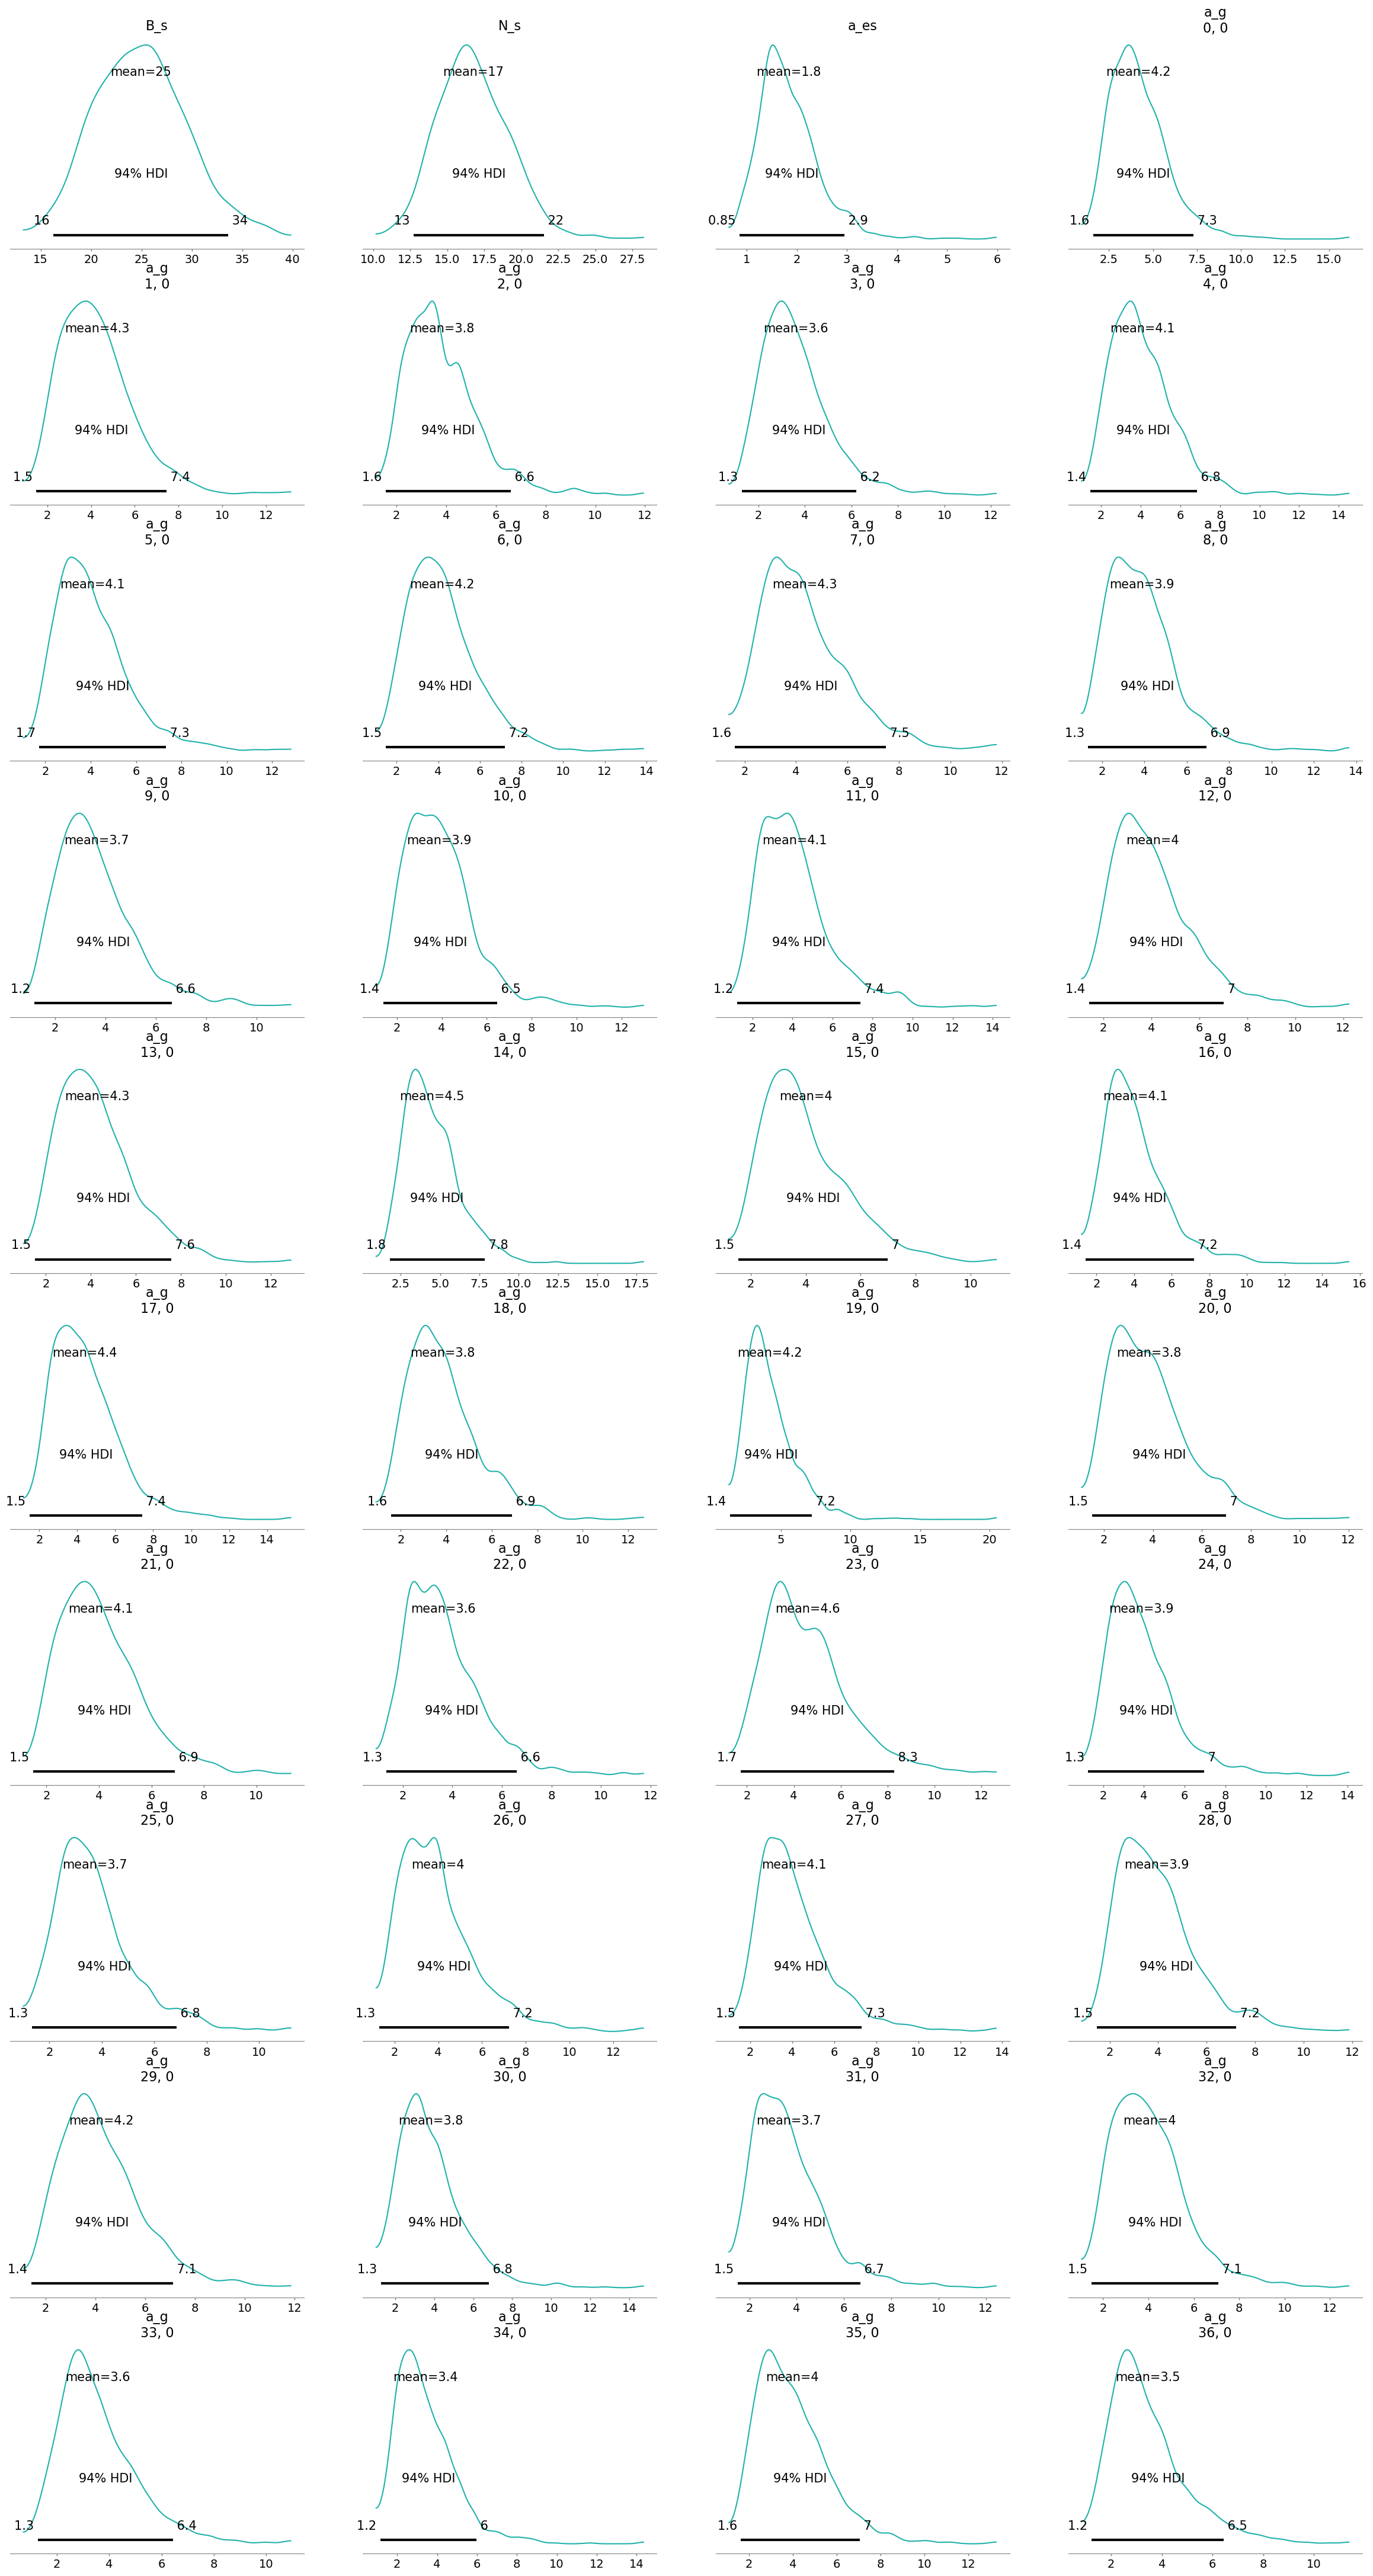

In [12]:
az.plot_posterior(mean_field.sample(1000), color="LightSeaGreen");

What if there are 4 sample batches ? 

In [8]:
import pymc_extras as pmx

In [10]:
with simNB_model:
    idata = pmx.fit(method="pathfinder", num_samples=10)


Running pathfinder...


2024-12-20 12:11:43.713603: W external/xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1007.93GiB (rounded to 1082253052928)requested by op 
2024-12-20 12:11:43.713885: W external/xla/xla/tsl/framework/bfc_allocator.cc:508] *******_____________________________________________________________________________________________
E1220 12:11:43.713923   73818 pjrt_stream_executor_client.cc:3085] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1082253052800 bytes.


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1082253052800 bytes.